[Probability and Statistics for Data Science](https://www.ps4ds.net/) 

Code for Example 10.32

Analysis of NBA regular-season games between 2012 and 2018 with the goal of quantifying the added value that players provide to their team. Our strategy is to compare the performance of the team with and without the player. The average difference in point differential is assessed by computing the corresponding p value using a permutation test\
Topics: Multiple testing, Bonferroni's correction, p value, permutation test, average treatment effect

Author: Carlos Fernandez-Granda\
Data source: https://www.kaggle.com/datasets/pablote/nba-enhanced-stats

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import binom
from scipy import stats
from datetime import datetime
import random
import time

font_size = 15
font_size_legend = 15
font_size_ticks = 15

player_data = pd.read_csv("../data/nba_2012_2018/2012-18_playerBoxScore.csv")
team_data = pd.read_csv("../data/nba_2012_2018/2012-18_teamBoxScore.csv")

In [ ]:
# This will take a long time to run, m_max can be reduced to make it faster, but the p values will be less accurate 
m_ini = int(1e4)
m_max = int(1e7)

players = np.unique(player_data['playDispNm'].values)

identifiers = []
ATEs = [] 
p_values = []
avg_minutes = []
verbose = True

# We iterate over all players
for player in players:
    print(player)
    games_aux = player_data[player_data['playDispNm'] == player]
    games = games_aux[games_aux["seasTyp"] == "Regular"]
    teams = np.unique(games['teamAbbr'].values)
    # We iterate over each of the teams the player played for
    for team in teams:
        print(team)
        identifier = player + " (" + team + ")"
        games_team_aux = team_data[team_data['teamAbbr'] == team]
        games_team = games_team_aux[games_team_aux["seasTyp"] == "Regular"]
        player_games_team = games[games['teamAbbr'] == team]
        avg_minutes_played = np.mean(player_games_team['playMin'].values)
        player_dates = player_games_team['gmDate'].values
        sorted_player_dates = sorted(player_dates, key=lambda x: datetime.strptime(x, '%Y-%m-%d'), reverse=False)
        point_differential_with = np.zeros(len(sorted_player_dates))
        for ind_date,date in enumerate(sorted_player_dates):
            game_date = games_team[games_team['gmDate'] == date]
            point_differential = game_date['teamPTS'].values[0] - game_date['opptPTS'].values[0]
            point_differential_with[ind_date] = point_differential
        
        initial_date = datetime.strptime(sorted_player_dates[0], '%Y-%m-%d')
        final_date = datetime.strptime(sorted_player_dates[-1], '%Y-%m-%d')
        print("Initial date",initial_date)
        print("Final date",final_date)
        team_dates = games_team['gmDate'].values
        sorted_team_dates = sorted(team_dates, key=lambda x: datetime.strptime(x, '%Y-%m-%d'), reverse=False)
        point_differential_without = np.array([])
        for date_team in sorted_team_dates:
            datetime_date = datetime.strptime(date_team, '%Y-%m-%d')
            if datetime_date > initial_date and datetime_date < final_date:
                if date_team not in sorted_player_dates:
                    game_without = games_team[games_team['gmDate'] == date_team]
                    point_differential = game_without['teamPTS'].values[0] - game_without['opptPTS'].values[0]
                    point_differential_without = np.append(point_differential_without,point_differential)
        n_with = len(point_differential_with)
        n_without = len(point_differential_without)
        
        if n_with >= 5 and n_without >= 5:
            identifiers.append(identifier)
            avg_minutes.append(avg_minutes_played)

            # Average treatment effect, where the effect is the point differential and the treatment is the presence of the player
            ATE = np.mean(point_differential_with) - np.mean(point_differential_without)
            ATEs.append(ATE)
        
            if verbose:
                print("Games with:",n_with,"Games without:",n_without,"Average minutes:",np.round(avg_minutes_played,1))
                print("ATE",np.round(ATE,3))
            
            point_differentials = np.append(point_differential_with,point_differential_without)
            
            done = False
            # We perform a permutation test
            m = m_ini
            while not done:
                start = time.time()
                aux_pval = 0
                for ind in range(m):
                    random.shuffle(point_differentials)
                    test_statistic_sample = np.mean(point_differentials[:n_with]) - np.mean(point_differentials[n_with:])
                    if test_statistic_sample >= ATE:
                        aux_pval += 1.
                end = time.time()
                if verbose:
                    print("Time",np.round(end - start,1))
                # We increase the number of permutations if we need higher precision
                # We are satisfied if we find at least 5 test statistics larger than the observed ATE
                if aux_pval > 5 or m == m_max:
                    p_val = aux_pval/m
                    done = True
                else: 
                    m = m * 10
                    if verbose:
                        print("Higher precision required",m)
            print('p value', p_val)
            p_values.append(p_val)


A.J. Hammons
DAL
Initial date 2016-10-28 00:00:00
Final date 2017-04-12 00:00:00
Games with: 22 Games without: 59 Average minutes: 7.3
ATE -8.815
Time 0.2
p value 0.9928
A.J. Price
CLE
Initial date 2014-12-04 00:00:00
Final date 2015-01-05 00:00:00
Games with: 11 Games without: 8 Average minutes: 8.0
ATE -8.977
Time 0.1
p value 0.9055
IND
Initial date 2014-11-07 00:00:00
Final date 2014-11-26 00:00:00
MIN
Initial date 2013-11-06 00:00:00
Final date 2014-03-05 00:00:00
Games with: 28 Games without: 28 Average minutes: 3.6
ATE 3.679
Time 0.2
p value 0.1713
PHO
Initial date 2015-03-21 00:00:00
Final date 2015-03-30 00:00:00
WAS
Initial date 2012-10-30 00:00:00
Final date 2013-04-17 00:00:00
Games with: 57 Games without: 25 Average minutes: 22.4
ATE 3.026
Time 0.2
p value 0.1451
Aaron Brooks
CHI
Initial date 2014-10-29 00:00:00
Final date 2016-04-13 00:00:00
Games with: 151 Games without: 13 Average minutes: 19.8
ATE 2.165
Time 0.4
p value 0.2807
DEN
Initial date 2014-02-21 00:00:00
Final 

Time 1.2
p value 0.844
Bogdan Bogdanovic
SAC
Initial date 2017-10-23 00:00:00
Final date 2018-04-11 00:00:00
Bojan Bogdanović
BKN
Initial date 2014-10-29 00:00:00
Final date 2017-02-15 00:00:00
Games with: 212 Games without:  8 Average minutes: 25.7
ATE -2.637
Time 1.1
p value 0.7198
IND
Initial date 2017-10-18 00:00:00
Final date 2018-04-08 00:00:00
WAS
Initial date 2017-02-24 00:00:00
Final date 2017-04-12 00:00:00
Boris Diaw
SA
Initial date 2012-10-31 00:00:00
Final date 2016-04-13 00:00:00
Games with: 311 Games without:  17 Average minutes: 22.7
ATE 4.5
Time 1.5
p value 0.0918
UTA
Initial date 2016-10-25 00:00:00
Final date 2017-04-12 00:00:00
Games with: 73 Games without:  9 Average minutes: 17.6
ATE -2.565
Time 0.5
p value 0.7079
Bradley Beal
WAS
Initial date 2012-10-30 00:00:00
Final date 2018-04-11 00:00:00
Games with: 406 Games without:  86 Average minutes: 33.9
ATE 2.962
Time 2.3
p value 0.0275
Brandan Wright
BOS
Initial date 2014-12-21 00:00:00
Final date 2015-01-05 00:00:00

Time 0.3
p value 0.7908
PHI
Initial date 2014-02-24 00:00:00
Final date 2014-04-12 00:00:00
Games with: 18 Games without:  6 Average minutes: 13.8
ATE -11.778
Time 0.2
p value 0.9726
C.J. McCollum
POR
Initial date 2014-01-08 00:00:00
Final date 2018-04-11 00:00:00
Games with: 341 Games without:  34 Average minutes: 29.1
ATE -2.067
Time 1.7
p value 0.8084
C.J. Miles
CLE
Initial date 2012-10-30 00:00:00
Final date 2014-03-18 00:00:00
Games with: 116 Games without:  34 Average minutes: 20.3
ATE 0.611
Time 0.7
p value 0.4011
IND
Initial date 2014-10-29 00:00:00
Final date 2017-04-12 00:00:00
Games with: 210 Games without:  36 Average minutes: 24.2
ATE -0.281
Time 1.1
p value 0.5534
TOR
Initial date 2017-10-19 00:00:00
Final date 2018-04-11 00:00:00
Games with: 70 Games without:  12 Average minutes: 19.1
ATE -4.4
Time 0.5
p value 0.8796
C.J. Watson
BKN
Initial date 2012-11-03 00:00:00
Final date 2013-04-17 00:00:00
IND
Initial date 2013-10-29 00:00:00
Final date 2015-04-03 00:00:00
Games wi

Time 0.8
p value 0.2941
Chinanu Onuaku
HOU
Initial date 2016-12-26 00:00:00
Final date 2018-04-11 00:00:00
Games with: 6 Games without:  127 Average minutes: 12.0
ATE -14.176
Time 0.7
p value 0.9945
Chris Andersen
CLE
Initial date 2016-10-25 00:00:00
Final date 2016-12-14 00:00:00
Games with: 12 Games without:  12 Average minutes: 9.6
ATE 7.0
Time 0.2
p value 0.1375
MEM
Initial date 2016-02-19 00:00:00
Final date 2016-04-13 00:00:00
Games with: 21 Games without:  8 Average minutes: 17.5
ATE 6.125
Time 0.2
p value 0.1495
MIA
Initial date 2013-01-25 00:00:00
Final date 2016-01-13 00:00:00
Games with: 181 Games without:  65 Average minutes: 17.6
ATE 5.546
Time 1.2
p value 0.001
Chris Babb
BOS
Initial date 2014-03-01 00:00:00
Final date 2014-04-16 00:00:00
Games with: 14 Games without:  9 Average minutes: 9.6
ATE -5.635
Time 0.2
p value 0.9124
Chris Bosh
MIA
Initial date 2012-10-30 00:00:00
Final date 2016-02-09 00:00:00
Games with: 250 Games without:  49 Average minutes: 33.3
ATE 2.394
Ti

Time 1.1
p value 0.2484
TOR
Initial date 2015-10-28 00:00:00
Final date 2017-04-12 00:00:00
Coty Clarke
BOS
Initial date 2016-03-15 00:00:00
Final date 2016-03-18 00:00:00
Courtney Lee
BOS
Initial date 2012-10-30 00:00:00
Final date 2014-01-03 00:00:00
Games with: 108 Games without:  6 Average minutes: 22.7
ATE 3.778
Time 0.6
p value 0.2509
CHA
Initial date 2016-02-21 00:00:00
Final date 2016-04-13 00:00:00
MEM
Initial date 2014-01-07 00:00:00
Final date 2016-02-10 00:00:00
Games with: 177 Games without:  7 Average minutes: 30.0
ATE -5.513
Time 0.9
p value 0.8865
NY
Initial date 2016-10-25 00:00:00
Final date 2018-04-09 00:00:00
Games with: 153 Games without:  10 Average minutes: 31.2
ATE 0.627
Time 0.8
p value 0.4572
Cristiano Felício
CHI
Initial date 2015-11-09 00:00:00
Final date 2018-04-11 00:00:00
Games with: 152 Games without:  87 Average minutes: 15.4
ATE -5.085
Time 1.2
p value 0.9959
D'Angelo Russell
BKN
Initial date 2017-10-18 00:00:00
Final date 2018-04-11 00:00:00
Games wit

Time 2.3
p value 0.8535
Darius Morris
BKN
Initial date 2014-12-12 00:00:00
Final date 2015-04-13 00:00:00
Games with: 38 Games without:  23 Average minutes: 7.9
ATE -6.802
Time 0.4
p value 0.9486
LAC
Initial date 2014-01-06 00:00:00
Final date 2014-01-25 00:00:00
LAL
Initial date 2012-11-02 00:00:00
Final date 2013-04-17 00:00:00
Games with: 48 Games without:  32 Average minutes: 14.2
ATE -0.979
Time 0.5
p value 0.6475
MEM
Initial date 2014-02-05 00:00:00
Final date 2014-02-12 00:00:00
PHI
Initial date 2013-10-30 00:00:00
Final date 2013-11-18 00:00:00
Darko Milicic
BOS
Initial date 2012-11-02 00:00:00
Final date 2012-11-02 00:00:00
Darrell Arthur
DEN
Initial date 2013-10-30 00:00:00
Final date 2018-03-21 00:00:00
Games with: 256 Games without:  144 Average minutes: 17.4
ATE -0.763
Time 1.8
p value 0.7055
MEM
Initial date 2012-11-23 00:00:00
Final date 2013-04-17 00:00:00
Games with: 59 Games without:  13 Average minutes: 16.5
ATE -5.1
Time 0.4
p value 0.9317
Darren Collison
DAL
Initia

Time 0.7
p value 0.4959
Derrick Favors
UTA
Initial date 2012-10-31 00:00:00
Final date 2018-04-11 00:00:00
Games with: 413 Games without:  79 Average minutes: 28.1
ATE -0.973
Time 2.3
p value 0.7087
Derrick Jones
MIA
Initial date 2018-01-05 00:00:00
Final date 2018-04-09 00:00:00
Games with: 14 Games without:  30 Average minutes: 15.3
ATE 1.676
Time 0.3
p value 0.3491
PHO
Initial date 2016-11-19 00:00:00
Final date 2017-11-24 00:00:00
Games with: 38 Games without:  51 Average minutes: 15.2
ATE -7.324
Time 0.5
p value 0.9946
Derrick Rose
CHI
Initial date 2013-10-29 00:00:00
Final date 2016-04-09 00:00:00
Games with: 127 Games without:  117 Average minutes: 31.0
ATE -0.055
Time 1.1
p value 0.5174
CLE
Initial date 2017-10-17 00:00:00
Final date 2018-02-07 00:00:00
Games with: 16 Games without:  37 Average minutes: 19.2
ATE -4.426
Time 0.3
p value 0.8568
MIN
Initial date 2018-03-11 00:00:00
Final date 2018-04-11 00:00:00
Games with: 9 Games without:  6 Average minutes: 12.6
ATE 8.722
Time 

Time 0.8
p value 0.8952
Draymond Green
GS
Initial date 2012-10-31 00:00:00
Final date 2018-04-10 00:00:00
Games with: 467 Games without:  25 Average minutes: 27.7
ATE -1.728
Time 2.2
p value 0.7286
Drew Gooden
MIL
Initial date 2012-12-07 00:00:00
Final date 2013-04-06 00:00:00
Games with: 17 Games without:  42 Average minutes: 9.2
ATE -0.934
Time 0.4
p value 0.6102
WAS
Initial date 2014-03-01 00:00:00
Final date 2016-04-13 00:00:00
Games with: 103 Games without:  85 Average minutes: 15.2
ATE 2.049
Time 0.9
p value 0.1672
Drew Gordon
PHI
Initial date 2014-11-13 00:00:00
Final date 2014-12-01 00:00:00
Duje Dukan
SAC
Initial date 2016-04-13 00:00:00
Final date 2016-04-13 00:00:00
Dwayne Bacon
CHA
Initial date 2017-10-18 00:00:00
Final date 2018-03-31 00:00:00
Games with: 53 Games without:  24 Average minutes: 13.4
ATE 1.208
Time 0.5
p value 0.3776
Dwight Buycks
DET
Initial date 2017-12-26 00:00:00
Final date 2018-03-24 00:00:00
Games with: 29 Games without:  12 Average minutes: 14.7
ATE -

Time 1.5
p value 0.0055
Eric Gordon
HOU
Initial date 2016-10-26 00:00:00
Final date 2018-04-10 00:00:00
Games with: 144 Games without:  19 Average minutes: 31.1
ATE -0.378
Time 0.8
p value 0.5443
NO
Initial date 2012-12-29 00:00:00
Final date 2016-03-05 00:00:00
Games with: 213 Games without:  65 Average minutes: 32.0
ATE 0.292
Time 1.3
p value 0.4364
Eric Maynor
OKC
Initial date 2012-11-01 00:00:00
Final date 2013-02-10 00:00:00
Games with: 37 Games without:  14 Average minutes: 10.6
ATE 10.459
Time 0.3
p value 0.0024
PHI
Initial date 2014-02-24 00:00:00
Final date 2014-03-12 00:00:00
POR
Initial date 2013-02-24 00:00:00
Final date 2013-04-17 00:00:00
WAS
Initial date 2013-10-30 00:00:00
Final date 2014-01-28 00:00:00
Games with: 23 Games without:  21 Average minutes: 9.2
ATE -0.727
Time 0.3
p value 0.5909
Eric Moreland
DET
Initial date 2017-10-18 00:00:00
Final date 2018-04-11 00:00:00
Games with: 67 Games without:  15 Average minutes: 12.0
ATE -0.261
Time 0.5
p value 0.5329
SAC
Init

Time 0.5
p value 0.321
MIA
Initial date 2015-10-28 00:00:00
Final date 2016-04-13 00:00:00
Games with: 69 Games without:  13 Average minutes: 22.6
ATE -4.808
Time 0.5
p value 0.8927
PHO
Initial date 2013-10-30 00:00:00
Final date 2015-04-14 00:00:00
Games with: 156 Games without:  8 Average minutes: 24.2
ATE -1.061
Time 0.8
p value 0.6008
Gerald Henderson
CHA
Initial date 2012-11-02 00:00:00
Final date 2015-04-15 00:00:00
Games with: 225 Games without:  21 Average minutes: 30.7
ATE -0.487
Time 1.1
p value 0.5719
PHI
Initial date 2016-10-26 00:00:00
Final date 2017-04-12 00:00:00
Games with: 72 Games without:  10 Average minutes: 23.2
ATE 1.6
Time 0.5
p value 0.3709
POR
Initial date 2015-11-11 00:00:00
Final date 2016-04-09 00:00:00
Gerald Wallace
BKN
Initial date 2012-11-03 00:00:00
Final date 2013-04-17 00:00:00
Games with: 69 Games without:  13 Average minutes: 30.1
ATE 0.105
Time 0.5
p value 0.4948
BOS
Initial date 2013-10-30 00:00:00
Final date 2015-04-15 00:00:00
Games with: 90 Ga

Time 0.4
p value 0.6386
NO
Initial date 2013-03-04 00:00:00
Final date 2013-03-09 00:00:00
PHI
Initial date 2014-02-24 00:00:00
Final date 2015-04-15 00:00:00
Games with: 99 Games without:  9 Average minutes: 21.3
ATE -7.616
Time 0.6
p value 0.9502
Henry Walker
MIA
Initial date 2015-02-23 00:00:00
Final date 2015-04-15 00:00:00
Hilton Armstrong
GS
Initial date 2013-12-11 00:00:00
Final date 2014-04-16 00:00:00
Games with: 15 Games without:  45 Average minutes: 6.6
ATE 3.444
Time 0.4
p value 0.1984
Hollis Thompson
NO
Initial date 2017-02-23 00:00:00
Final date 2017-03-11 00:00:00
PHI
Initial date 2013-11-01 00:00:00
Final date 2017-01-03 00:00:00
Games with: 256 Games without:  22 Average minutes: 24.4
ATE 4.314
Time 1.3
p value 0.0684
Ian Clark
DEN
Initial date 2015-04-01 00:00:00
Final date 2015-04-15 00:00:00
GS
Initial date 2015-10-30 00:00:00
Final date 2017-04-12 00:00:00
Games with: 143 Games without:  20 Average minutes: 12.0
ATE 3.551
Time 0.8
p value 0.1373
NO
Initial date 201

Time 1.6
p value 0.8655
Jack Cooley
SAC
Initial date 2017-11-18 00:00:00
Final date 2018-04-11 00:00:00
Games with: 7 Games without:  60 Average minutes: 12.4
ATE 3.26
Time 0.4
p value 0.2325
UTA
Initial date 2015-02-27 00:00:00
Final date 2015-04-15 00:00:00
Games with: 16 Games without:  10 Average minutes: 5.4
ATE -0.7
Time 0.2
p value 0.562
Jacob Pullen
PHI
Initial date 2017-11-20 00:00:00
Final date 2017-12-23 00:00:00
Jacob Wiley
BKN
Initial date 2017-10-29 00:00:00
Final date 2017-12-09 00:00:00
Games with: 6 Games without:  13 Average minutes: 5.5
ATE -7.936
Time 0.2
p value 0.9581
Jae Crowder
BOS
Initial date 2014-12-21 00:00:00
Final date 2017-04-12 00:00:00
Games with: 202 Games without:  20 Average minutes: 29.9
ATE 3.57
Time 1.1
p value 0.0978
CLE
Initial date 2017-10-17 00:00:00
Final date 2018-02-07 00:00:00
DAL
Initial date 2012-10-30 00:00:00
Final date 2014-12-17 00:00:00
Games with: 181 Games without:  10 Average minutes: 15.9
ATE 6.771
Time 0.9
p value 0.0625
UTA
In

Time 0.3
p value 0.043
DAL
Initial date 2012-10-31 00:00:00
Final date 2013-01-07 00:00:00
Games with: 8 Games without:  26 Average minutes: 3.4
ATE 9.856
Time 0.3
p value 0.0602
LAC
Initial date 2014-11-02 00:00:00
Final date 2015-01-03 00:00:00
Games with: 19 Games without:  13 Average minutes: 4.7
ATE 4.421
Time 0.3
p value 0.1954
MIL
Initial date 2016-03-20 00:00:00
Final date 2016-03-25 00:00:00
SAC
Initial date 2014-03-31 00:00:00
Final date 2014-04-16 00:00:00
Jared Dudley
LAC
Initial date 2013-10-29 00:00:00
Final date 2014-04-16 00:00:00
Games with: 74 Games without:  8 Average minutes: 23.4
ATE -3.905
Time 0.5
p value 0.7784
MIL
Initial date 2014-10-29 00:00:00
Final date 2015-04-12 00:00:00
Games with: 72 Games without:  8 Average minutes: 23.8
ATE 9.306
Time 0.5
p value 0.023
PHO
Initial date 2012-10-31 00:00:00
Final date 2018-04-10 00:00:00
Games with: 192 Games without:  300 Average minutes: 22.0
ATE -5.283
Time 2.2
p value 1.0
WAS
Initial date 2015-10-30 00:00:00
Final 

Time 0.5
p value 0.7765
Jeff Withey
DAL
Initial date 2017-10-21 00:00:00
Final date 2017-12-14 00:00:00
Games with: 10 Games without:  17 Average minutes: 3.9
ATE -5.824
Time 0.2
p value 0.8316
NO
Initial date 2013-11-01 00:00:00
Final date 2015-04-08 00:00:00
Games with: 95 Games without:  64 Average minutes: 9.9
ATE -4.661
Time 0.8
p value 0.9884
UTA
Initial date 2015-10-31 00:00:00
Final date 2017-04-12 00:00:00
Games with: 102 Games without:  60 Average minutes: 10.7
ATE 3.429
Time 0.8
p value 0.0677
Jeffery Taylor
CHA
Initial date 2012-11-03 00:00:00
Final date 2015-04-15 00:00:00
Games with: 132 Games without:  113 Average minutes: 19.5
ATE -5.664
Time 1.1
p value 0.9994
Jerami Grant
OKC
Initial date 2016-11-02 00:00:00
Final date 2018-04-11 00:00:00
PHI
Initial date 2014-11-29 00:00:00
Final date 2016-10-29 00:00:00
Games with: 144 Games without:  7 Average minutes: 24.2
ATE -3.898
Time 0.7
p value 0.7955
Jerel McNeal
PHO
Initial date 2015-04-02 00:00:00
Final date 2015-04-14 00

Time 0.8
Higher precision required 100000
Time 7.4
Higher precision required 1000000
Time 76.2
p value 2.4e-05
Joel Freeland
POR
Initial date 2012-11-02 00:00:00
Final date 2015-04-15 00:00:00
Games with: 151 Games without:  94 Average minutes: 12.0
ATE -0.794
Time 1.2
p value 0.6832
Joel Przybilla
MIL
Initial date 2012-11-03 00:00:00
Final date 2013-02-11 00:00:00
Games with: 12 Games without:  37 Average minutes: 5.8
ATE -6.714
Time 0.3
p value 0.9577
Joey Dorsey
HOU
Initial date 2014-11-01 00:00:00
Final date 2015-04-15 00:00:00
Games with: 69 Games without:  11 Average minutes: 12.4
ATE 4.299
Time 0.5
p value 0.1377
Joffrey Lauvergne
CHI
Initial date 2017-02-25 00:00:00
Final date 2017-04-12 00:00:00
DEN
Initial date 2015-02-22 00:00:00
Final date 2016-04-10 00:00:00
Games with: 83 Games without:  26 Average minutes: 15.8
ATE 1.969
Time 0.6
p value 0.2452
OKC
Initial date 2016-10-28 00:00:00
Final date 2017-02-15 00:00:00
Games with: 50 Games without:  6 Average minutes: 14.8
ATE 4

Time 0.4
p value 0.8518
Jordan McRae
CLE
Initial date 2016-02-28 00:00:00
Final date 2017-02-23 00:00:00
Games with: 53 Games without:  28 Average minutes: 9.4
ATE 4.294
Time 0.5
p value 0.0895
PHO
Initial date 2016-01-29 00:00:00
Final date 2016-02-19 00:00:00
Jordan Mickey
BOS
Initial date 2015-10-28 00:00:00
Final date 2017-04-06 00:00:00
Games with: 41 Games without:  120 Average minutes: 4.9
ATE -3.643
Time 0.8
p value 0.957
MIA
Initial date 2017-10-21 00:00:00
Final date 2018-04-04 00:00:00
Games with: 23 Games without:  55 Average minutes: 12.3
ATE 2.771
Time 0.5
p value 0.187
Jorge Gutierrez
BKN
Initial date 2014-03-09 00:00:00
Final date 2014-12-10 00:00:00
Games with: 25 Games without:  17 Average minutes: 11.6
ATE -4.002
Time 0.3
p value 0.825
CHA
Initial date 2016-02-24 00:00:00
Final date 2016-04-13 00:00:00
Games with: 12 Games without:  15 Average minutes: 5.3
ATE 9.817
Time 0.2
p value 0.0178
MIL
Initial date 2015-01-29 00:00:00
Final date 2015-04-15 00:00:00
Games with

Time 0.5
p value 0.9593
Justin Patton
MIN
Initial date 2018-04-01 00:00:00
Final date 2018-04-01 00:00:00
Justise Winslow
MIA
Initial date 2015-10-28 00:00:00
Final date 2018-04-11 00:00:00
Games with: 164 Games without:  82 Average minutes: 27.7
ATE -1.848
Time 1.2
p value 0.8644
Jusuf Nurkic
DEN
Initial date 2014-10-29 00:00:00
Final date 2017-02-10 00:00:00
Games with: 139 Games without:  78 Average minutes: 17.7
ATE 0.078
Time 1.0
p value 0.4791
POR
Initial date 2017-02-15 00:00:00
Final date 2018-04-11 00:00:00
Games with: 99 Games without:  10 Average minutes: 27.0
ATE 2.41
Time 0.6
p value 0.2698
Juwan Howard
MIA
Initial date 2013-03-24 00:00:00
Final date 2013-04-17 00:00:00
Games with: 7 Games without:  7 Average minutes: 7.0
ATE 9.286
Time 0.2
p value 0.0613
K.J. McDaniels
BKN
Initial date 2017-02-25 00:00:00
Final date 2017-04-12 00:00:00
HOU
Initial date 2015-02-21 00:00:00
Final date 2017-02-11 00:00:00
Games with: 76 Games without:  91 Average minutes: 6.3
ATE 4.904
Time 

Time 0.4
p value 0.8985
MIL
Initial date 2013-10-30 00:00:00
Final date 2018-04-11 00:00:00
Games with: 351 Games without:  59 Average minutes: 33.0
ATE -1.695
Time 1.9
p value 0.8305
Kim English
DET
Initial date 2012-10-31 00:00:00
Final date 2013-04-17 00:00:00
Games with: 41 Games without:  41 Average minutes: 10.0
ATE -4.902
Time 0.5
p value 0.9391
Kirk Hinrich
ATL
Initial date 2016-02-26 00:00:00
Final date 2016-04-13 00:00:00
Games with: 11 Games without:  13 Average minutes: 6.8
ATE 5.615
Time 0.2
p value 0.1481
CHI
Initial date 2012-10-31 00:00:00
Final date 2016-02-10 00:00:00
Games with: 235 Games without:  63 Average minutes: 25.7
ATE 3.523
Time 1.4
p value 0.027
Klay Thompson
GS
Initial date 2012-10-31 00:00:00
Final date 2018-04-10 00:00:00
Games with: 471 Games without:  21 Average minutes: 34.1
ATE 9.976
Time 2.2
p value 0.0009
Kleiza Linas
TOR
Initial date 2012-11-10 00:00:00
Final date 2012-12-28 00:00:00
Games with: 20 Games without:  5 Average minutes: 18.8
ATE 3.9
T

Time 0.2
p value 0.3872
Larry Drew
NO
Initial date 2018-03-17 00:00:00
Final date 2018-04-04 00:00:00
PHI
Initial date 2015-01-16 00:00:00
Final date 2018-01-29 00:00:00
Games with: 15 Games without:  240 Average minutes: 15.7
ATE 2.367
Time 1.1
p value 0.2443
Larry Nance Jr.
CLE
Initial date 2018-02-11 00:00:00
Final date 2018-04-11 00:00:00
LAL
Initial date 2015-11-06 00:00:00
Final date 2018-02-06 00:00:00
Games with: 168 Games without:  45 Average minutes: 21.6
ATE -0.803
Time 1.0
p value 0.6369
Larry Sanders
CLE
Initial date 2017-03-14 00:00:00
Final date 2017-04-10 00:00:00
Games with: 5 Games without:  11 Average minutes: 2.4
ATE 6.745
Time 0.2
p value 0.2537
MIL
Initial date 2012-11-02 00:00:00
Final date 2014-12-23 00:00:00
Games with: 121 Games without:  72 Average minutes: 25.7
ATE 3.29
Time 0.9
p value 0.0294
Lauri Markkanen
CHI
Initial date 2017-10-19 00:00:00
Final date 2018-04-11 00:00:00
Games with: 68 Games without:  14 Average minutes: 29.7
ATE 2.038
Time 0.5
p value 

Time 0.4
p value 0.5708
Luke Zeller
PHO
Initial date 2012-11-04 00:00:00
Final date 2013-02-10 00:00:00
Games with: 16 Games without:  34 Average minutes: 3.8
ATE -4.779
Time 0.3
p value 0.8761
Luol Deng
CHI
Initial date 2012-10-31 00:00:00
Final date 2014-01-04 00:00:00
Games with: 98 Games without:  16 Average minutes: 38.4
ATE 1.735
Time 0.6
p value 0.3213
CLE
Initial date 2014-01-10 00:00:00
Final date 2014-04-09 00:00:00
LAL
Initial date 2016-10-26 00:00:00
Final date 2017-10-19 00:00:00
Games with: 57 Games without:  26 Average minutes: 26.2
ATE -0.056
Time 0.5
p value 0.5089
MIA
Initial date 2014-10-29 00:00:00
Final date 2016-04-13 00:00:00
Games with: 146 Games without:  18 Average minutes: 32.9
ATE 5.269
Time 0.9
p value 0.0562
Maalik Wayns
LAC
Initial date 2013-03-10 00:00:00
Final date 2014-01-10 00:00:00
Games with: 8 Games without:  49 Average minutes: 5.9
ATE 9.143
Time 0.4
p value 0.0433
PHI
Initial date 2012-10-31 00:00:00
Final date 2013-01-08 00:00:00
Games with: 21 

Time 0.5
p value 0.1176
Markieff Morris
PHO
Initial date 2012-10-31 00:00:00
Final date 2016-02-10 00:00:00
Games with: 282 Games without:  18 Average minutes: 26.6
ATE 0.972
Time 1.4
p value 0.3827
WAS
Initial date 2016-02-19 00:00:00
Final date 2018-04-11 00:00:00
Games with: 176 Games without:  18 Average minutes: 28.7
ATE -3.381
Time 0.9
p value 0.8644
Marquese Chriss
PHO
Initial date 2016-10-26 00:00:00
Final date 2018-04-06 00:00:00
Games with: 154 Games without:  8 Average minutes: 21.2
ATE 1.679
Time 0.8
p value 0.3638
Marquis Daniels
MIL
Initial date 2012-11-02 00:00:00
Final date 2013-04-17 00:00:00
Games with: 59 Games without:  23 Average minutes: 18.4
ATE -0.937
Time 0.5
p value 0.641
Marquis Teague
BKN
Initial date 2014-01-31 00:00:00
Final date 2014-04-16 00:00:00
Games with: 21 Games without:  18 Average minutes: 9.4
ATE 0.214
Time 0.3
p value 0.4748
CHI
Initial date 2012-11-02 00:00:00
Final date 2013-12-25 00:00:00
Games with: 67 Games without:  41 Average minutes: 9.

Time 0.3
p value 0.9771
DAL
Initial date 2013-01-09 00:00:00
Final date 2013-04-17 00:00:00
NO
Initial date 2018-01-30 00:00:00
Final date 2018-02-05 00:00:00
PHO
Initial date 2017-10-18 00:00:00
Final date 2017-12-20 00:00:00
Mike Miller
CLE
Initial date 2014-10-30 00:00:00
Final date 2015-04-15 00:00:00
Games with: 52 Games without:  30 Average minutes: 13.5
ATE -4.033
Time 0.5
p value 0.8696
DEN
Initial date 2015-10-28 00:00:00
Final date 2017-04-12 00:00:00
Games with: 66 Games without:  98 Average minutes: 8.0
ATE -2.249
Time 0.9
p value 0.8735
MEM
Initial date 2013-10-30 00:00:00
Final date 2014-04-16 00:00:00
MIA
Initial date 2012-10-30 00:00:00
Final date 2013-04-17 00:00:00
Games with: 59 Games without:  23 Average minutes: 15.2
ATE 1.989
Time 0.5
p value 0.2451
Mike Muscala
ATL
Initial date 2014-03-02 00:00:00
Final date 2018-04-10 00:00:00
Games with: 243 Games without:  110 Average minutes: 14.7
ATE -2.073
Time 1.7
p value 0.9047
Mike Scott
ATL
Initial date 2012-11-11 00:00

Time 0.8
p value 0.8933
Nick Collison
OKC
Initial date 2012-11-01 00:00:00
Final date 2018-04-11 00:00:00
Games with: 322 Games without:  170 Average minutes: 15.4
ATE 3.872
Time 2.2
p value 0.0012
Nick Johnson
HOU
Initial date 2014-11-01 00:00:00
Final date 2015-04-15 00:00:00
Games with: 28 Games without:  52 Average minutes: 9.4
ATE -0.69
Time 0.5
p value 0.6064
Nick Young
GS
Initial date 2017-10-17 00:00:00
Final date 2018-04-10 00:00:00
LAL
Initial date 2013-10-29 00:00:00
Final date 2017-03-17 00:00:00
Games with: 220 Games without:  95 Average minutes: 24.6
ATE 3.595
Time 1.4
p value 0.0176
PHI
Initial date 2012-10-31 00:00:00
Final date 2013-04-17 00:00:00
Games with: 59 Games without:  23 Average minutes: 24.0
ATE -3.556
Time 0.5
p value 0.8901
Nicolas Batum
CHA
Initial date 2015-10-28 00:00:00
Final date 2018-04-10 00:00:00
Games with: 211 Games without:  35 Average minutes: 33.4
ATE 0.499
Time 1.1
p value 0.4225
POR
Initial date 2012-10-31 00:00:00
Final date 2015-04-13 00:0

Time 0.8
p value 0.0486
Pat Connaughton
POR
Initial date 2015-10-30 00:00:00
Final date 2018-04-11 00:00:00
Games with: 155 Games without:  90 Average minutes: 12.6
ATE -0.811
Time 1.1
p value 0.6799
Patricio Garino
ORL
Initial date 2017-04-04 00:00:00
Final date 2017-04-12 00:00:00
Patrick Beverley
HOU
Initial date 2013-01-15 00:00:00
Final date 2017-04-12 00:00:00
Games with: 292 Games without:  80 Average minutes: 28.4
ATE 1.499
Time 1.7
p value 0.1857
LAC
Initial date 2017-10-19 00:00:00
Final date 2017-11-20 00:00:00
Games with: 11 Games without:  5 Average minutes: 30.3
ATE 9.564
Time 0.2
p value 0.1756
Patrick Christopher
UTA
Initial date 2014-12-27 00:00:00
Final date 2015-01-02 00:00:00
Patrick McCaw
GS
Initial date 2016-10-25 00:00:00
Final date 2018-03-31 00:00:00
Games with: 128 Games without:  30 Average minutes: 15.9
ATE 2.873
Time 0.8
p value 0.1774
Patrick Mills
SA
Initial date 2012-10-31 00:00:00
Final date 2018-04-11 00:00:00
Games with: 433 Games without:  59 Average

Time 1.2
p value 0.9504
Randy Foye
BKN
Initial date 2016-11-08 00:00:00
Final date 2017-04-12 00:00:00
Games with: 69 Games without:  7 Average minutes: 18.6
ATE -3.089
Time 0.5
p value 0.726
DEN
Initial date 2013-10-30 00:00:00
Final date 2016-02-10 00:00:00
Games with: 186 Games without:  32 Average minutes: 25.0
ATE -2.926
Time 1.1
p value 0.8731
OKC
Initial date 2016-02-21 00:00:00
Final date 2016-04-12 00:00:00
UTA
Initial date 2012-10-31 00:00:00
Final date 2013-04-17 00:00:00
Rashad Vaughn
BKN
Initial date 2018-02-06 00:00:00
Final date 2018-02-06 00:00:00
MIL
Initial date 2015-10-28 00:00:00
Final date 2018-02-04 00:00:00
Games with: 133 Games without:  83 Average minutes: 12.3
ATE -2.951
Time 1.0
p value 0.9536
ORL
Initial date 2018-02-22 00:00:00
Final date 2018-03-03 00:00:00
Rashard Lewis
MIA
Initial date 2012-10-30 00:00:00
Final date 2014-04-14 00:00:00
Games with: 115 Games without:  48 Average minutes: 15.3
ATE 4.123
Time 0.8
p value 0.0232
Rasual Butler
IND
Initial dat

Time 1.1
p value 0.4496
Rodrigue Beaubois
DAL
Initial date 2012-10-30 00:00:00
Final date 2013-03-17 00:00:00
Games with: 45 Games without:  21 Average minutes: 12.3
ATE -7.975
Time 0.4
p value 0.9836
Roger Mason
MIA
Initial date 2013-10-30 00:00:00
Final date 2014-01-26 00:00:00
Games with: 25 Games without:  18 Average minutes: 10.4
ATE 4.973
Time 0.3
p value 0.0732
NO
Initial date 2012-10-31 00:00:00
Final date 2013-04-17 00:00:00
Games with: 69 Games without:  13 Average minutes: 17.7
ATE -5.234
Time 0.5
p value 0.9132
Ron Baker
NY
Initial date 2016-10-25 00:00:00
Final date 2018-01-30 00:00:00
Games with: 81 Games without:  52 Average minutes: 15.3
ATE -5.517
Time 0.7
p value 0.9963
Rondae Hollis-Jefferson
BKN
Initial date 2015-10-28 00:00:00
Final date 2018-04-11 00:00:00
Games with: 175 Games without:  71 Average minutes: 24.6
ATE 2.713
Time 1.1
p value 0.0559
Ronnie Brewer
CHI
Initial date 2014-04-14 00:00:00
Final date 2014-04-14 00:00:00
HOU
Initial date 2013-11-01 00:00:00
F

Time 0.7
p value 0.9894
CHI
Initial date 2018-03-27 00:00:00
Final date 2018-04-11 00:00:00
DEN
Initial date 2016-01-15 00:00:00
Final date 2016-02-01 00:00:00
LAC
Initial date 2018-03-04 00:00:00
Final date 2018-03-20 00:00:00
MIL
Initial date 2017-12-22 00:00:00
Final date 2018-02-28 00:00:00
Games with: 23 Games without:  9 Average minutes: 8.9
ATE -0.343
Time 0.3
p value 0.5323
MIN
Initial date 2015-03-19 00:00:00
Final date 2015-03-27 00:00:00
Sebastian Telfair
OKC
Initial date 2014-10-29 00:00:00
Final date 2014-11-26 00:00:00
PHO
Initial date 2012-10-31 00:00:00
Final date 2013-02-10 00:00:00
Games with: 46 Games without:  6 Average minutes: 17.3
ATE 4.971
Time 0.4
p value 0.2005
TOR
Initial date 2013-02-27 00:00:00
Final date 2013-04-06 00:00:00
Games with: 13 Games without:  7 Average minutes: 14.2
ATE 4.956
Time 0.2
p value 0.2404
Semaj Christon
OKC
Initial date 2016-10-26 00:00:00
Final date 2017-04-12 00:00:00
Games with: 64 Games without:  18 Average minutes: 15.2
ATE -0.5

Time 0.3
p value 0.9437
Sonny Weems
PHI
Initial date 2016-03-12 00:00:00
Final date 2016-03-26 00:00:00
PHO
Initial date 2015-10-28 00:00:00
Final date 2016-03-03 00:00:00
Games with: 36 Games without:  25 Average minutes: 11.8
ATE -7.38
Time 0.4
p value 0.9801
Spencer Dinwiddie
BKN
Initial date 2016-12-10 00:00:00
Final date 2018-04-09 00:00:00
DET
Initial date 2014-10-29 00:00:00
Final date 2016-04-13 00:00:00
Games with: 46 Games without:  118 Average minutes: 13.4
ATE -2.388
Time 0.8
p value 0.8692
Spencer Hawes
CHA
Initial date 2015-10-28 00:00:00
Final date 2017-02-01 00:00:00
Games with: 92 Games without:  40 Average minutes: 18.0
ATE -1.355
Time 0.7
p value 0.7141
CLE
Initial date 2014-02-21 00:00:00
Final date 2014-04-16 00:00:00
LAC
Initial date 2014-10-30 00:00:00
Final date 2015-04-14 00:00:00
Games with: 73 Games without:  9 Average minutes: 17.5
ATE 5.9
Time 0.5
p value 0.1151
MIL
Initial date 2017-03-03 00:00:00
Final date 2017-04-12 00:00:00
PHI
Initial date 2012-10-31 

Time 0.5
p value 0.9888
HOU
Initial date 2013-02-27 00:00:00
Final date 2013-04-14 00:00:00
LAL
Initial date 2016-10-28 00:00:00
Final date 2017-04-12 00:00:00
Games with: 48 Games without:  33 Average minutes: 11.6
ATE -2.998
Time 0.5
p value 0.8039
PHI
Initial date 2015-02-25 00:00:00
Final date 2015-04-15 00:00:00
POR
Initial date 2013-10-30 00:00:00
Final date 2015-02-11 00:00:00
Games with: 102 Games without:  33 Average minutes: 12.4
ATE 0.566
Time 0.7
p value 0.406
SAC
Initial date 2012-10-31 00:00:00
Final date 2013-02-19 00:00:00
Thon Maker
MIL
Initial date 2016-10-30 00:00:00
Final date 2018-04-11 00:00:00
Games with: 131 Games without:  31 Average minutes: 13.8
ATE 0.601
Time 0.8
p value 0.4046
Tiago Splitter
ATL
Initial date 2015-10-27 00:00:00
Final date 2016-01-31 00:00:00
Games with: 36 Games without:  13 Average minutes: 16.1
ATE 1.538
Time 0.4
p value 0.3624
PHI
Initial date 2017-03-28 00:00:00
Final date 2017-04-12 00:00:00
SA
Initial date 2012-10-31 00:00:00
Final da

Time 0.6
p value 0.4228
IND
Initial date 2018-03-07 00:00:00
Final date 2018-04-10 00:00:00
PHI
Initial date 2017-12-09 00:00:00
Final date 2018-02-25 00:00:00
UTA
Initial date 2014-10-29 00:00:00
Final date 2016-04-13 00:00:00
Games with: 158 Games without:  6 Average minutes: 20.2
ATE 3.466
Time 0.8
p value 0.281
WAS
Initial date 2012-10-30 00:00:00
Final date 2014-04-16 00:00:00
Games with: 120 Games without:  44 Average minutes: 20.4
ATE 1.773
Time 0.8
p value 0.1977
Trey Burke
NY
Initial date 2018-01-15 00:00:00
Final date 2018-04-11 00:00:00
UTA
Initial date 2013-11-20 00:00:00
Final date 2016-03-28 00:00:00
Games with: 210 Games without:  16 Average minutes: 28.1
ATE -4.268
Time 1.1
p value 0.8714
WAS
Initial date 2016-10-27 00:00:00
Final date 2017-04-12 00:00:00
Games with: 57 Games without:  25 Average minutes: 12.3
ATE 3.345
Time 0.5
p value 0.0979
Trey Lyles
DEN
Initial date 2017-10-18 00:00:00
Final date 2018-04-09 00:00:00
Games with: 73 Games without:  8 Average minutes:

Time 0.5
p value 0.0021
OKC
Initial date 2016-10-26 00:00:00
Final date 2017-04-12 00:00:00
Games with: 67 Games without:  15 Average minutes: 33.2
ATE 2.639
Time 0.5
p value 0.2528
ORL
Initial date 2013-10-29 00:00:00
Final date 2016-04-08 00:00:00
Games with: 224 Games without:  19 Average minutes: 33.2
ATE 1.894
Time 1.2
p value 0.2608
Vince Carter
DAL
Initial date 2012-10-30 00:00:00
Final date 2014-04-16 00:00:00
MEM
Initial date 2014-10-29 00:00:00
Final date 2017-04-12 00:00:00
Games with: 199 Games without:  47 Average minutes: 19.6
ATE 2.717
Time 1.2
p value 0.108
SAC
Initial date 2017-10-18 00:00:00
Final date 2018-04-11 00:00:00
Games with: 58 Games without:  24 Average minutes: 17.7
ATE 4.376
Time 0.5
p value 0.0692
Vince Hunter
MEM
Initial date 2017-12-01 00:00:00
Final date 2017-12-20 00:00:00
Vitor Faverani
BOS
Initial date 2013-10-30 00:00:00
Final date 2014-01-28 00:00:00
Games with: 37 Games without:  10 Average minutes: 13.2
ATE -2.111
Time 0.3
p value 0.6982
Vladimi

Time 0.8
p value 0.0799
Zhou Qi
HOU
Initial date 2017-10-21 00:00:00
Final date 2018-04-11 00:00:00
Games with: 18 Games without:  62 Average minutes: 6.8
ATE 4.586
Time 0.5
p value 0.0815
Zoran Dragić
MIA
Initial date 2015-02-23 00:00:00
Final date 2015-04-15 00:00:00
Games with: 10 Games without:  18 Average minutes: 6.1
ATE -6.189
Time 0.3
p value 0.9144
PHO
Initial date 2014-11-15 00:00:00
Final date 2015-02-05 00:00:00
Games with: 6 Games without:  36 Average minutes: 2.3
ATE -11.139
Time 0.3
p value 0.9795
Álex Abrines
OKC
Initial date 2016-10-26 00:00:00
Final date 2018-04-09 00:00:00
Games with: 143 Games without:  20 Average minutes: 15.3
ATE -0.1
Time 0.8
p value 0.5112


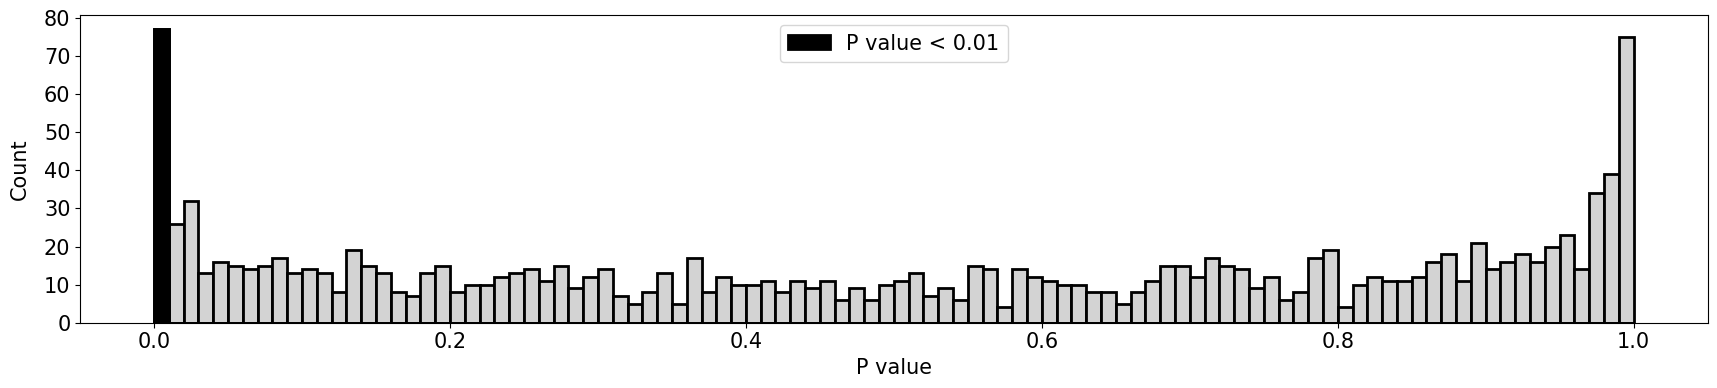

In [5]:
pvals = np.array(p_values)
avg_mins = np.array(avg_minutes)

plt.figure(figsize=(21,4))
plt.hist(pvals,bins=np.arange(0,1+1e-2,1e-2),color = "lightgray", edgecolor="black",linewidth = 2)
plt.hist(pvals[pvals < 1e-2],bins=np.arange(0,1+1e-2,1e-2),color = "black", edgecolor="black",
         linewidth = 2,label="P value < 0.01")
plt.xticks([0,0.2,0.4,0.6,0.8,1],fontsize=font_size_ticks) 
plt.yticks(fontsize=font_size_ticks)
plt.xlim([-5e-2,1+5e-2])
plt.xlabel(r"P value",fontsize=font_size_ticks)
plt.ylabel(r'Count',labelpad = 10,fontsize=font_size_ticks)
plt.legend(fontsize=font_size_legend);

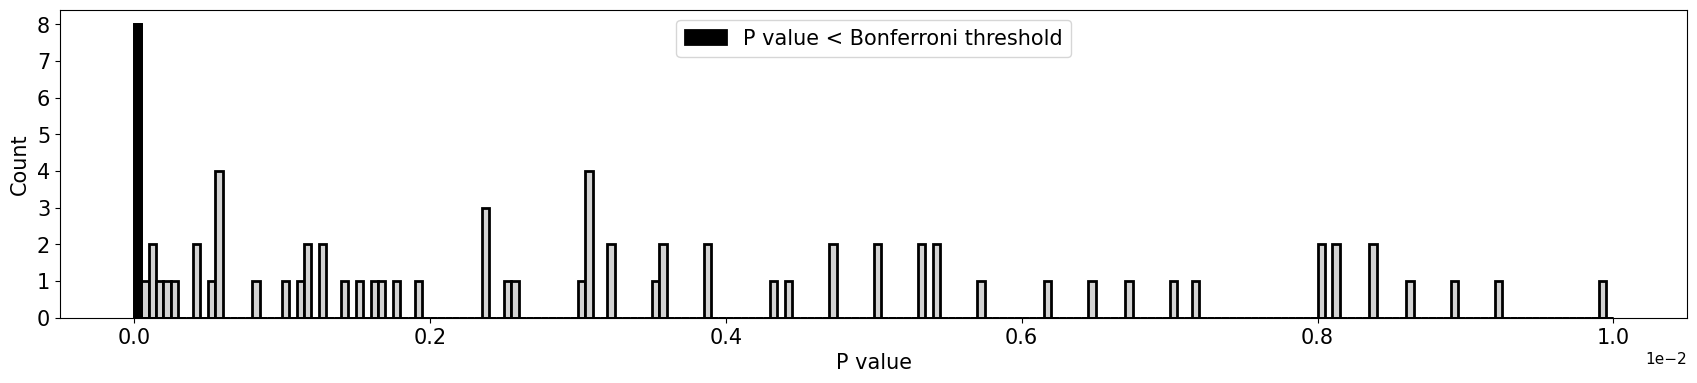

In [6]:
pvals_thresh = pvals[pvals<10e-3]
avg_mins_thresh = avg_mins[pvals<0.05]

bin_vals = np.arange(0,1e-2+5e-5,5e-5)

plt.figure(figsize=(21,4))
plt.hist(pvals_thresh,bins=bin_vals,color = "lightgray", edgecolor="black",linewidth = 2)
plt.hist(pvals_thresh[pvals_thresh < 5e-5],bins=bin_vals,color = "black", edgecolor="black",
         linewidth = 2,label="P value < Bonferroni threshold")
plt.yticks(fontsize=font_size_ticks)
plt.xticks(fontsize=font_size_ticks)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xlim([-5e-4,10e-3+5e-4])
ax = plt.gca()
ax.xaxis.get_offset_text().set_fontsize(font_size_ticks-4)
plt.xlabel(r"P value",fontsize=font_size_ticks)
plt.ylabel(r'Count',labelpad = 5,fontsize=font_size_ticks)
plt.legend(fontsize=font_size_legend,loc="upper center");

In [7]:
# Players ordered by the difference in average point differential with and without them  
sort_inds = (-np.array(ATEs)).argsort()
for ind in sort_inds:
    print(identifiers[ind],"ATE:",np.round(ATEs[ind],3),"p value:",p_values[ind],"Average minutes:",np.round(avg_minutes[ind],1))

Marcus Paige (CHA) ATE: 28.5 p value: 0.00019 Average minutes: 5.4
Nazr Mohammed (OKC) ATE: 18.5 p value: 0.0031 Average minutes: 4.0
Georges Niang (UTA) ATE: 17.126 p value: 0.00011 Average minutes: 3.7
LeBron James (CLE) ATE: 16.65 p value: 0.0 Average minutes: 36.6
Andrew Goudelock (HOU) ATE: 16.514 p value: 0.0304 Average minutes: 6.4
Bruno Caboclo (TOR) ATE: 16.399 p value: 0.0 Average minutes: 4.6
Roy Hibbert (DEN) ATE: 16.133 p value: 0.0025 Average minutes: 2.0
Brandon Knight (DET) ATE: 16.101 p value: 0.0019 Average minutes: 31.5
Michael Gbinije (DET) ATE: 15.835 p value: 0.0039 Average minutes: 3.4
DeMarre Carroll (BKN) ATE: 15.658 p value: 0.0016 Average minutes: 29.9
Enes Kanter (NY) ATE: 15.451 p value: 0.0044 Average minutes: 25.8
MarShon Brooks (GS) ATE: 15.429 p value: 0.0535 Average minutes: 2.4
Victor Oladipo (IND) ATE: 15.02 p value: 0.003 Average minutes: 34.1
Ronnie Brewer (OKC) ATE: 13.69 p value: 0.0024 Average minutes: 10.1
Jared Cunningham (ATL) ATE: 12.489 p v

In [9]:
# Players ordered by the p value associated with the difference in average point differential with and without them 
sort_inds = pvals.argsort()
for ind in sort_inds:
    print(identifiers[ind],"ATE:",np.round(ATEs[ind],3),"p value:",p_values[ind],"Average minutes:",np.round(avg_minutes[ind],1))

Bruno Caboclo (TOR) ATE: 16.399 p value: 0.0 Average minutes: 4.6
LeBron James (CLE) ATE: 16.65 p value: 0.0 Average minutes: 36.6
Nikola Mirotić (CHI) ATE: 10.268 p value: 3e-07 Average minutes: 23.1
Carmelo Anthony (NY) ATE: 8.13 p value: 6e-07 Average minutes: 36.3
Ricky Rubio (MIN) ATE: 7.57 p value: 9e-07 Average minutes: 31.4
James Jones (MIA) ATE: 8.199 p value: 5.9e-06 Average minutes: 7.8
Brandon Rush (GS) ATE: 6.739 p value: 6e-06 Average minutes: 12.6
Joel Embiid (PHI) ATE: 8.687 p value: 2.1e-05 Average minutes: 28.7
Kevin Durant (OKC) ATE: 6.848 p value: 9e-05 Average minutes: 37.3
Georges Niang (UTA) ATE: 17.126 p value: 0.00011 Average minutes: 3.7
Chris Paul (LAC) ATE: 6.832 p value: 0.00014 Average minutes: 33.6
Marcus Paige (CHA) ATE: 28.5 p value: 0.00019 Average minutes: 5.4
Kevin Garnett (MIN) ATE: 9.239 p value: 0.00022 Average minutes: 15.3
Stephen Curry (GS) ATE: 8.18 p value: 0.00028 Average minutes: 34.6
Nikola Pekovic (MIN) ATE: 4.982 p value: 0.0004 Average 

Damien Wilkins (IND) ATE: 1.666 p value: 0.3716 Average minutes: 8.0
Tony Allen (MEM) ATE: 0.496 p value: 0.3734 Average minutes: 25.8
Marcus Georges-Hunt (MIN) ATE: 0.881 p value: 0.3754 Average minutes: 5.4
Nikola Jokić (DEN) ATE: 0.98 p value: 0.3755 Average minutes: 27.2
Stephen Zimmerman (ORL) ATE: 1.349 p value: 0.3764 Average minutes: 5.8
Dwayne Bacon (CHA) ATE: 1.208 p value: 0.3776 Average minutes: 13.4
Jordan Hamilton (LAC) ATE: 1.643 p value: 0.379 Average minutes: 8.8
Robin Lopez (POR) ATE: 0.836 p value: 0.3791 Average minutes: 30.1
Caron Butler (MIL) ATE: 1.038 p value: 0.3792 Average minutes: 24.1
Toney Douglas (MIA) ATE: 1.566 p value: 0.3795 Average minutes: 15.3
Lavoy Allen (PHI) ATE: 1.448 p value: 0.3799 Average minutes: 20.2
Jodie Meeks (LAL) ATE: 1.399 p value: 0.3805 Average minutes: 27.2
Markieff Morris (PHO) ATE: 0.972 p value: 0.3827 Average minutes: 26.6
Chandler Parsons (DAL) ATE: 0.965 p value: 0.3828 Average minutes: 31.4
R.J. Hunter (BOS) ATE: 0.813 p val

Trey Lyles (UTA) ATE: -1.733 p value: 0.6685 Average minutes: 16.8
Shabazz Napier (MIA) ATE: -1.451 p value: 0.6687 Average minutes: 19.9
E'Twaun Moore (ORL) ATE: -1.718 p value: 0.6697 Average minutes: 20.7
Gary Harris (DEN) ATE: -0.842 p value: 0.6709 Average minutes: 28.4
Daequan Cook (CHI) ATE: -1.899 p value: 0.6711 Average minutes: 8.4
Paul Zipser (CHI) ATE: -1.14 p value: 0.6729 Average minutes: 17.0
Robert Covington (HOU) ATE: -2.353 p value: 0.6737 Average minutes: 5.0
D'Angelo Russell (BKN) ATE: -1.221 p value: 0.6766 Average minutes: 25.7
Salah Mejri (DAL) ATE: -0.792 p value: 0.6777 Average minutes: 12.2
Justin Anderson (DAL) ATE: -1.281 p value: 0.6782 Average minutes: 12.8
Malik Monk (CHA) ATE: -1.722 p value: 0.6793 Average minutes: 13.5
Ian Mahinmi (WAS) ATE: -1.054 p value: 0.6799 Average minutes: 15.8
Pat Connaughton (POR) ATE: -0.811 p value: 0.6799 Average minutes: 12.6
Luis Montero (POR) ATE: -1.899 p value: 0.6805 Average minutes: 3.5
Jalen Jones (DAL) ATE: -2.208

Lance Thomas (NY) ATE: -2.227 p value: 0.8967 Average minutes: 21.5
Jabari Bird (BOS) ATE: -4.185 p value: 0.8967 Average minutes: 8.8
Ivica Zubac (LAL) ATE: -2.959 p value: 0.8969 Average minutes: 12.6
Carlos Boozer (CHI) ATE: -5.67 p value: 0.8976 Average minutes: 30.3
Khris Middleton (DET) ATE: -4.554 p value: 0.8985 Average minutes: 17.7
Charlie Villanueva (DAL) ATE: -3.266 p value: 0.8995 Average minutes: 10.7
Tyler Johnson (MIA) ATE: -2.087 p value: 0.8997 Average minutes: 26.7
Kay Felder (CHI) ATE: -8.5 p value: 0.9011 Average minutes: 9.6
James Johnson (TOR) ATE: -2.88 p value: 0.9013 Average minutes: 18.0
Noah Vonleh (POR) ATE: -3.237 p value: 0.9013 Average minutes: 15.8
Tyler Ennis (LAL) ATE: -3.698 p value: 0.9014 Average minutes: 14.1
Amir Johnson (TOR) ATE: -4.55 p value: 0.9031 Average minutes: 28.0
Alex Kirk (CLE) ATE: -10.0 p value: 0.904 Average minutes: 2.8
Mike Muscala (ATL) ATE: -2.073 p value: 0.9047 Average minutes: 14.7
A.J. Price (CLE) ATE: -8.977 p value: 0.90